In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os
import time

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

from palettable.colorbrewer.sequential import Greys_9
from scipy.optimize import curve_fit

In [2]:
os.chdir('../Debiasing/')

In [3]:
import make_dictionaries
questions = make_dictionaries.questions
sample = Table.read('../fits/full_sample_debiased.fits')
print('Loaded galaxy data...')
a40 = Table.read('../fits/ALFALFA/a40.csv')
a40_reference = Table.read('../fits/ALFALFA/a40_ref.csv')
print('Loaded ALFALFA-40 data.')

Loaded galaxy data...
Loaded ALFALFA-40 data.


# First need to match the $\alpha$40 catalogues:

Mass limit = 9.89


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


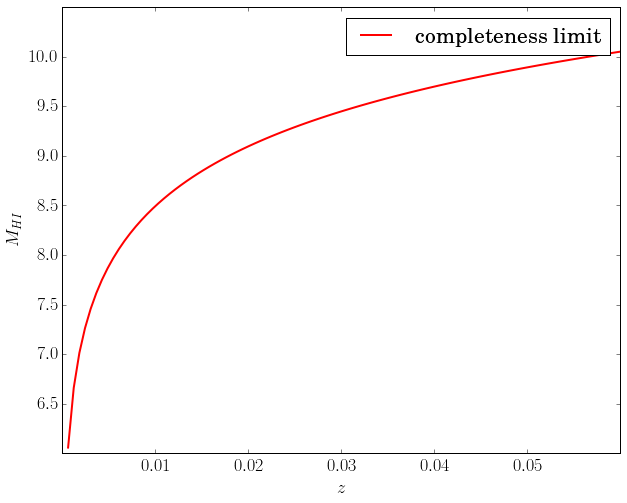

In [14]:
def find_matches(list1,list2):
    '''Find matches between 2 sets of numbers or strings'''
    match_values = set(list1).intersection(list2) # matches
    match_array = np.zeros((len(match_values),2))
    for i,m in enumerate(match_values):
        match_array[i,0] = np.where(np.in1d(list1,m))[0]
        match_array[i,1] = np.where(np.in1d(list2,m))[0]
    
    return match_array.astype(int)


def mass_from_redshift(z):
    K = 2.356e5*((3e5/70)**2) # constant for converting between flux and mass
    mass_limit = np.log10(K*(z**2)*0.72)
    return mass_limit

z = np.linspace(0,0.06,100)
_ = plt.plot(z,mass_from_redshift(z),'r-',lw=2,label='completeness limit')
_ = plt.legend()
plt.xlabel('$z$')
plt.ylabel('$M_{HI}$')

mass_limit = mass_from_redshift(0.05)
print('Mass limit = {0:.2f}'.format(mass_limit))

a40_matches = find_matches(a40['AGCNr'],a40_reference['AGCNr'])
a40 = a40[a40_matches[:,0]]
a40_reference = a40_reference[a40_matches[:,1]]
# Remove incomplete gas masses
mass_limited = a40['logMsun'] >= 9.89
a40 = a40[mass_limited]
a40_reference = a40_reference[mass_limited]

# Cut out a volume-limited (and stellar mass-limited) sample:

In [15]:
def get_spiral_sample(data,questions,in_volume_limit=None,in_mass_limit=None,printout=True,p_th=None):
    
    if in_volume_limit == None:
        in_volume_limit = np.ones(len(data))
        
    select_p = (data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
                *data['t02_edgeon_a05_no_debiased_rh']*data['t04_spiral_a08_spiral_debiased_rh']) > 0.5
    select_N = (data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count']) >= 5
    
    if in_mass_limit == None:
        select = (in_volume_limit) & (select_p) & (select_N)
    else:
        select = (in_volume_limit) & (select_p) & (select_N) & (in_mass_limit)
        
    answers = questions['t11_arms_number']['answers'][:-1]
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers]
    arm_array = np.array([data[A] for A in arm_answers]).T
    arm_assignments = np.argmax(arm_array,axis=1)
    if p_th != None:
        p_values = np.max(arm_array,axis=1)
        arm_assignments[p_values < p_th] = -999
        
    if printout:
        print('{}/{} selected'.format(np.sum(select),len(select)))
        for m in range(5):
            print('m={}: {}/{} spiral galaxies selected'.format(m+1,np.sum(arm_assignments[select] == m)
                                                         ,len(arm_assignments[select] == m)))
    
    return select,arm_assignments

In [16]:
in_volume_limit = ((sample['REDSHIFT_1'] <= 0.05) # <-- Masters+10, Haynes+11 etc.
                   & (sample['REDSHIFT_1'] >= 0.03)
                   & (sample['PETROMAG_MR'] <= -19.78))

in_mass_limit = sample['LOGMSTAR_BALDRY06'] >= 10.1 # new value (from plot below)
print('Stellar mass-limited sample:{} galaxies'.format(np.sum((in_volume_limit) & (in_mass_limit))))
select_spirals,m_values = get_spiral_sample(sample,questions,in_volume_limit,printout=False)
print('---> w. {} spiral galaxies'.format(np.sum((in_volume_limit) & (in_mass_limit) & (select_spirals))))

Stellar mass-limited sample:20047 galaxies
---> w. 5359 spiral galaxies


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


In [17]:
import astropy.units as u
import astropy.coordinates as coord

ra_min = coord.ICRS(ra=7.5,dec=10,unit=(u.hourangle, u.degree))
ra_max = coord.ICRS(ra=16.5,dec=10,unit=(u.hourangle,u.degree))
ra_limits = [ra_min.ra.deg,ra_max.ra.deg]
select_ra = (sample['ra_1'] >= ra_limits[0]) & (sample['ra_1'] <= ra_limits[1])
select_dec1 = (sample['dec_1'] >= 4) & (sample['dec_1'] <= 16)
select_dec2 = (sample['dec_1'] >= 24) & (sample['dec_1'] <= 28)
select_dec = [any(s) for s in zip(select_dec1,select_dec2)]
select_spatial = (select_ra) & (select_dec)

print('{}/{} of SDSS in the ALFALFA-40 coverage'.format(np.sum(select_spatial),len(select_spatial))
      + ' ({0:.1f}%)'.format(np.sum(select_spatial)/len(select_spatial)*100))

61430/228201 of SDSS in the ALFALFA-40 coverage (26.9%)


# Match $\alpha$40 to our spirals:

1554/5359 spiral galaxies in the a40 spatial selection
706/5359 spiral galaxies have a40 matches


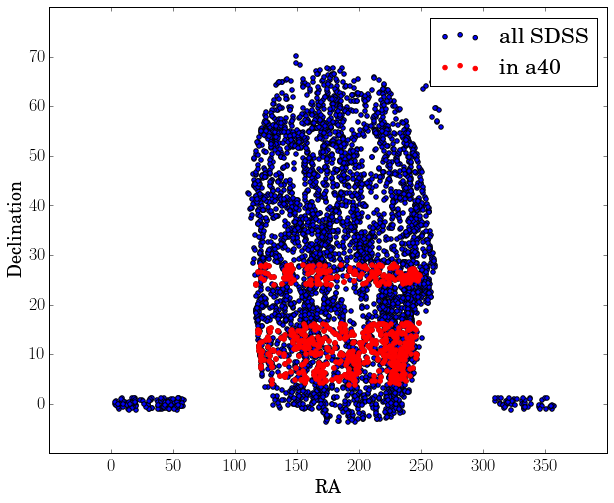

In [18]:
ml_spirals = np.all([in_volume_limit,in_mass_limit,select_spirals],axis=0)
ml_spirals_spatial = np.all([ml_spirals,select_spatial],axis=0)
print('{}/{} spiral galaxies in the a40 spatial selection'.format(ml_spirals_spatial.sum()
                                                                  ,ml_spirals.sum()))

m_ml = m_values[ml_spirals]
m_ml_spatial = m_values[ml_spirals_spatial]
# Now match a40:
matches = find_matches(sample['dr7objid_1'],a40_reference['PhotoObjID'])
match_mask = np.zeros(len(sample)).astype(bool)
match_mask[matches[:,0]] = True
ml_spirals_matched = np.all([ml_spirals,match_mask],axis=0)
print('{}/{} spiral galaxies have a40 matches'.format(ml_spirals_matched.sum()
                                                      ,ml_spirals.sum()))

_ = plt.scatter(sample[ml_spirals]['ra_1'],sample[ml_spirals]['dec_1'],label='all SDSS')
_ = plt.scatter(sample[ml_spirals_matched]['ra_1'],sample[ml_spirals_matched]['dec_1'],color='r',label='in a40')
plt.xlabel('RA')
plt.ylabel('Declination')
_ = plt.legend()

m_ml_a40 = m_values[ml_spirals_matched]

# Are we preferentially losing 1 type of galaxy over another?

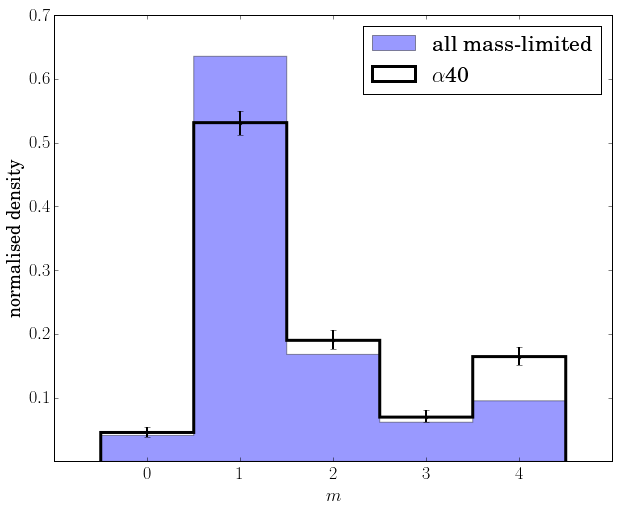

In [24]:
import scipy.stats.distributions as dist

def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper

def get_fractions_w_errors(data):
    
    fracs = np.array(data)/np.sum(data)
    fracs_low,fracs_high = get_fractional_errors(np.array(data),np.sum(data))
    fracs_table = Table(np.array([fracs_low,fracs,fracs_high]).T,
                        names=('f_low','f','f_high'))
    return fracs_table

field_sample = []
a40_sample = []
m_vals = range(5)
bins = np.linspace(-0.5,4.5,6)

for m in m_vals:
    field_sample.append((m_ml == m).sum())
    a40_sample.append((m_ml_a40 == m).sum())
    
field_fracs = get_fractions_w_errors(field_sample)
a40_fracs = get_fractions_w_errors(a40_sample)

_ = plt.hist(m_ml,normed=True,bins=bins,histtype='stepfilled',color='b',alpha=0.4,label='all mass-limited')
h = plt.hist(m_ml_a40,normed=True,bins=bins,histtype='step',color='k',lw=3,label=r'$\alpha$40')
_ = plt.legend()

a40_density = a40_fracs
normalisation = h[0][0]/a40_fracs['f'][0]
for c in field_fracs.colnames:
    a40_density[c] = a40_fracs[c]*normalisation

_ = plt.errorbar(m_vals,a40_density['f'],fmt='.',color='k',lw=2,
                 yerr=[a40_density['f']-a40_density['f_low'],a40_density['f_high']-a40_density['f']])

plt.xlabel('$m$')
plt.ylabel('normalised density')

In [ ]:
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins


def get_fractions(column,bins,th=0.5):
    
    fracs = np.zeros(len(np.unique(bins)))
    
    for m,b in enumerate(np.unique(bins)):
        
        bin_data = column[bins == b]
        fracs[m] = np.sum(bin_data > th)/len(bin_data)
        
    return fracs


def plot_by_column(x_column,y_column,color='k',label='___',nbins=10):

    x,bins = bin_by_column(x_column,nbins=nbins)
    x = []
    x_error = []
    y = []
    y_error = []

    for b in np.unique(bins):
    
        x.append(np.mean(x_column[bins == b]))
        x_error.append(np.std(x_column[bins == b]/np.sqrt(len(x_column[bins == b]))))
        y.append(np.mean(y_column[bins == b]))
        y_error.append(np.std(y_column[bins == b]/np.sqrt(len(y_column[bins == b]))))
        
    plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o',color=color,linewidth=2,label=label)
    
    return None


def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper


def get_arm_fraction(column,bins,m):
    
    N_b = len(np.unique(bins))
    fractions = np.zeros(N_b)
    upper_fracs = np.zeros(N_b)
    lower_fracs = np.zeros(N_b)
    
    for n,b in enumerate(np.unique(bins)):
        
        bin_col = column[bins == b]
        bin_m = np.sum(bin_col == m)
        bin_tot = len(bin_col)
        
        f_low,f_high = get_fractional_errors(bin_m,bin_tot)
        fractions[n] = bin_m/bin_tot
        lower_fracs[n] = f_low
        upper_fracs[n] = f_high
    
    fractions_table = Table(np.array([lower_fracs,fractions,upper_fracs]).T
                            ,names=('low_f','f','high_f'))
    
    return fractions_table


def plot_by_column_abs(x_column,assignments,color='k',label='___',nbins=10,m_vals=[2]):
    
    x,bins = bin_by_column(x_column,nbins=nbins)
    
    n = []
    k = []
    
    for b in np.unique(bins):
        
        a_b = assignments[bins == b]
        in_m = a_b == 1000
        for m in m_vals:
            in_m = in_m + (a_b == m)
        k.append(len(a_b))
        n.append(np.sum(in_m))
        
    n = np.array(n)
    k = np.array(k)
    
    fractions = np.zeros(len(n))
    upper_fracs = np.zeros(len(n))
    lower_fracs = np.zeros(len(n))
    
    f = n/k
    f_low,f_high = get_fractional_errors(n,k)
    lower_fracs = f_low
    upper_fracs = f_high
        
    plt.errorbar(x,f,yerr=[f-f_low,f_high-f],fmt='o',color=color,linewidth=2,label=label)
    
    return None

In [31]:
ml_m = m_values[ml_spirals]
ml_matches = find_matches(sample[ml_spirals]['dr7objid_1'],a40_reference['PhotoObjID'])

matched_galaxies = sample[ml_spirals][ml_matches[:,0]]
matched_a40 = a40[ml_matches[:,1]]
matched_a40_reference = a40_reference[ml_matches[:,1]]
matched_m = ml_m[ml_matches[:,0]]
bar_values = np.argmax(np.array([matched_galaxies['t03_bar_' + a + '_debiased_rh'] 
                                 for a in ['a06_bar','a07_no_bar']]).T,axis=1)

log_fgas = (matched_a40['logMsun'] - matched_galaxies['LOGMSTAR_BALDRY06'])
fgas = 10**log_fgas

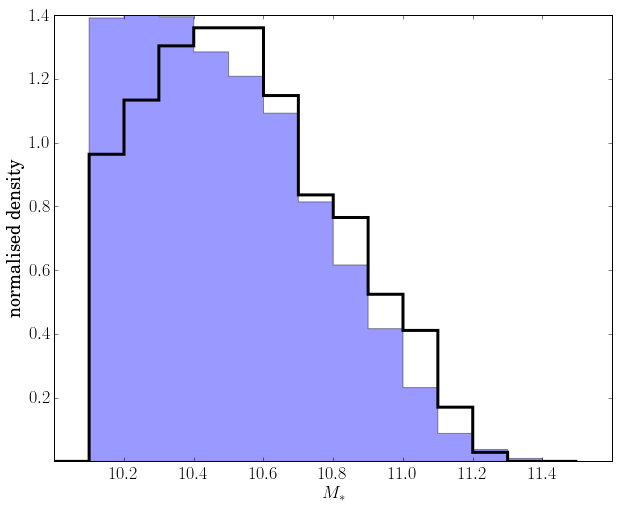

In [40]:
bins = np.linspace(10,11.5,16)
_ = plt.hist(sample[ml_spirals]['LOGMSTAR_BALDRY06'],histtype='stepfilled',alpha=0.4,color='b',normed=True,bins=bins)
_ = plt.hist(matched_galaxies['LOGMSTAR_BALDRY06'],histtype='step',color='k',lw=3,normed=True,bins=bins)
plt.xlabel('$M_*$')
plt.ylabel('normalised density')

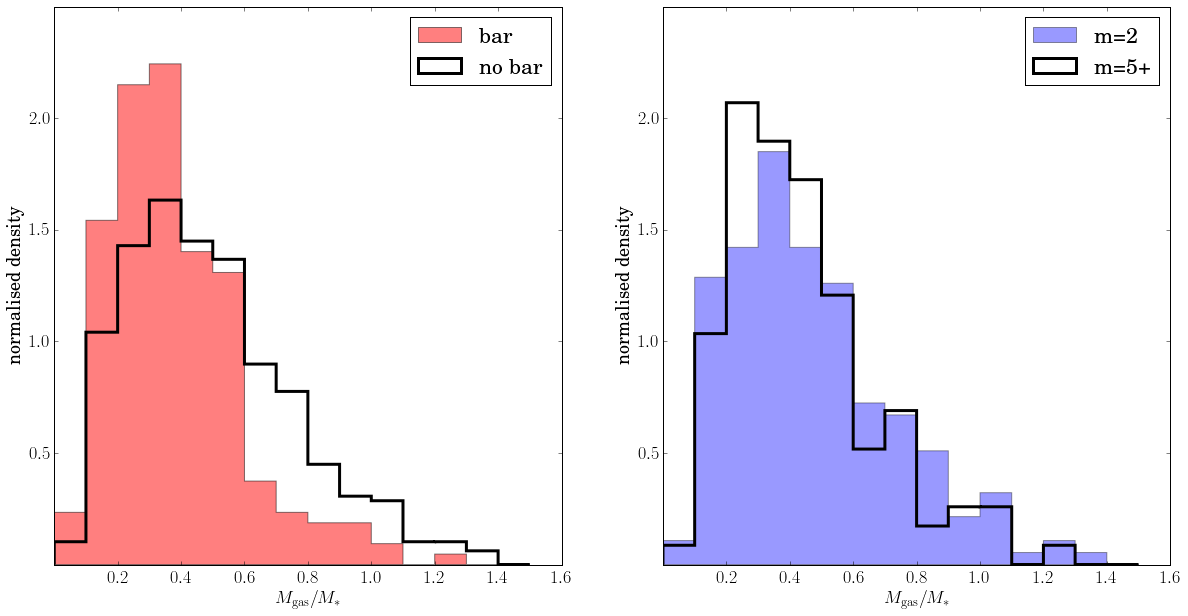

In [49]:
fig,axarr = plt.subplots(1,2,figsize=(20,10))
bins = np.linspace(0,1.5,16)

plt.sca(axarr[0])
_ = plt.hist(fgas[bar_values == 0],bins=bins,normed=True,
             histtype='stepfilled',color='r',alpha=0.5,label='bar')
_ = plt.hist(fgas[bar_values == 1],bins=bins,normed=True,
             histtype='step',lw=3,color='k',label='no bar')
plt.xlabel('$M_{\mathrm{gas}}/M_*$')
plt.ylabel('normalised density')
_ = plt.legend()

plt.sca(axarr[1])
_ = plt.hist(fgas[matched_m == 1],bins=bins,normed=True,
             histtype='stepfilled',color='b',alpha=0.4,label='m=2')
_ = plt.hist(fgas[matched_m == 4],bins=bins,normed=True,
             histtype='step',lw=3,color='k',label='m=5+')
plt.xlabel('$M_{\mathrm{gas}}/M_*$')
plt.ylabel('normalised density')
_ = plt.legend()

In [203]:
from sklearn.preprocessing import scale
from sklearn.cross_validation import KFold
from sklearn.neighbors.kde import KernelDensity
from astroML.linear_model import NadarayaWatson

def xyz_contour(x,y,z,xlabel='x',ylabel='y',zlabel='z'
                ,h='minimise',cbar=True,plot_bandwidth=None,spacing=0.1):
    
    finite = (np.isfinite(x)) & (np.isfinite(y)) & (np.isfinite(z))
    x,y,z = [x[finite],y[finite],z[finite]]
    
    x_scaled,y_scaled = [scale(x),scale(y)]
    xy = np.array([x_scaled,y_scaled]).T
    
    x_grid_raw = np.linspace(np.min(x),np.max(x),100)
    y_grid_raw = np.linspace(np.min(y),np.max(y),100)
    
    x_grid = np.linspace(np.min(x_scaled),np.max(x_scaled),100)
    y_grid = np.linspace(np.min(y_scaled),np.max(y_scaled),100)
    x_g,y_g = np.array(np.meshgrid(x_grid,y_grid))
    xy_grid = np.array([x_g.ravel().squeeze(),y_g.ravel().squeeze()]).T
    
    if h == 'minimise':
        residuals,h_values = get_xyz_bandwidth(x_scaled,y_scaled,z)
        h = h_values[np.argmin(residuals)]
        print('best h found = {0:.2f}'.format(h))
    
    clf = NadarayaWatson('gaussian',h)
    clf.fit(xy,z)
    z_fit = clf.predict(xy_grid)

    plt.contourf(x_grid_raw,y_grid_raw,z_fit.reshape(100,100),
                 levels=np.linspace(np.min(z_fit),np.max(z_fit),1000),
                 cmap=Greys_9.mpl_colormap)
    
    plt.xlim(x_grid_raw[0],x_grid_raw[-1])
    plt.ylim(y_grid_raw[0],y_grid_raw[-1])

    if cbar:
        cb = plt.colorbar()
        cb.set_ticks(np.arange(-5,5,spacing))
        cb.set_label(zlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if plot_bandwidth != None:
        len_xb = h*np.std(x)/2
        len_yb = h*np.std(y)/2
        xmin,xmax = [x_grid_raw[0],x_grid_raw[-1]]
        ymin,ymax = [y_grid_raw[0],y_grid_raw[-1]]
        x_pos = xmin + 0.9*(xmax-xmin)
        y_pos = ymin + 0.9*(ymax-ymin)

        plt.hlines(y_pos,x_pos-len_xb,x_pos+len_xb,color=plot_bandwidth,lw=2)
        plt.vlines(x_pos,y_pos-len_yb,y_pos+len_yb,color=plot_bandwidth,lw=2)
    return None
        

def get_xyz_bandwidth(x,y,z,plot=False):
    
    xy = np.array([x,y]).T
    
    kf = KFold(n=len(x),n_folds=3,shuffle=True,random_state=0)
    h_arr = np.logspace(-1,1,20)
    def get_h_residual(h_arr,kf):
        residuals = []
        for h in h_arr:
            residual = []
            for train,test in kf:
                training_xy = xy[train]
                training_z = z[train]
                test_xy = xy[test]
                test_z = z[test]
                clf = NadarayaWatson('gaussian',h=h)
                clf.fit(training_xy, training_z)
                z_fit = clf.predict(test_xy)
                
                residual.append(np.sum((test_z - z_fit)**2))
            residuals.append(np.sum(residual))
        return residuals
    
    residuals = get_h_residual(h_arr,kf)
    if plot:
        plt.figure()
        plt.plot(h_arr,residuals,lw=2)
        plt.xlabel('h')
        plt.ylabel('$\Sigma \chi ^2$')
        
    h_arr_precise = np.linspace(h_arr[np.argmin(residuals)-1],h_arr[np.argmin(residuals)+1],20)
    residuals = get_h_residual(h_arr_precise,kf)
    if plot:
        plt.figure()
        plt.plot(h_arr_precise,residuals,lw=2)
        plt.xlabel('h')
        plt.ylabel('$\Sigma \chi ^2$')

    return residuals,h_arr_precise
        
###################################################

In [204]:
from sklearn.neighbors.kde import KernelDensity
from sklearn.grid_search import GridSearchCV

def xy_contour(x,y,xlabel='x',ylabel='y'
               ,h='minimise',plot_bandwidth=None,
               spacing=0.1,levels=[0.2,0.4,0.6,0.8],color='r'):
    
    finite = (np.isfinite(x)) & (np.isfinite(y))
    x,y = [x[finite],y[finite]]
    
    x_scaled,y_scaled = [scale(x),scale(y)]
    xy = np.array([x_scaled,y_scaled]).T
    
    x_grid_raw = np.linspace(np.min(x),np.max(x),100)
    y_grid_raw = np.linspace(np.min(y),np.max(y),100)
    
    x_grid = np.linspace(np.min(x_scaled),np.max(x_scaled),100)
    y_grid = np.linspace(np.min(y_scaled),np.max(y_scaled),100)
    x_g,y_g = np.array(np.meshgrid(x_grid,y_grid))
    xy_grid = np.array([x_g.ravel().squeeze(),y_g.ravel().squeeze()]).T
    
    if h == 'minimise':
        h = get_xy_bandwidth(xy)
        #h = h_values[np.argmin(residuals)]
        print('best h found = {0:.2f}'.format(h))
    
    clf = KernelDensity(kernel='gaussian',bandwidth=h).fit(xy)
    z_fit = np.exp(clf.score_samples(xy_grid).reshape(100,100))
    # Rest is taken from the triangle.py method of plotting fractional data contours.
    #--------------------------------------------------------------------------------
    Hflat = z_fit.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    sm = np.cumsum(Hflat)
    sm /= sm[-1]
    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]
    # ------------------------------------------------------------------------------
    
    plt.contour(x_grid_raw,y_grid_raw,z_fit,levels=V,linewidths=2,colors=color,zorder=1)
    
    plt.xlim(x_grid_raw[0],x_grid_raw[-1])
    plt.ylim(y_grid_raw[0],y_grid_raw[-1])
    
    if plot_bandwidth != None:
        len_xb = h*np.std(x)/2
        len_yb = h*np.std(y)/2
        xmin,xmax = [x_grid_raw[0],x_grid_raw[-1]]
        ymin,ymax = [y_grid_raw[0],y_grid_raw[-1]]
        x_pos = xmin + 0.9*(xmax-xmin)
        y_pos = ymin + 0.9*(ymax-ymin)

        plt.hlines(y_pos,x_pos-len_xb,x_pos+len_xb,color=plot_bandwidth,linewidths=2)
        plt.vlines(x_pos,y_pos-len_yb,y_pos+len_yb,color=plot_bandwidth,linewidths=2)
    return None


def get_xy_bandwidth(xy_grid):
    
    params = {'bandwidth': np.logspace(-1,0.3,100)}
    kf = KFold(n=len(xy_grid),n_folds=3,shuffle=True,random_state=0)
    grid = GridSearchCV(KernelDensity(), params,cv=kf)
    grid.fit(xy_grid)
    
    return grid.best_estimator_.bandwidth 

In [ ]:
def get_p(sample,question,answer,questions,exclude=False):
    
    answers = questions[question]['answers']
    if exclude:
        answers = answers[:-1]
    
    m = np.array([sample[question + '_' + A + '_debiased_rh'] for A in answers]).T
    p = m[:,answer]/np.sum(m,axis=1)
    return p

p_2 = get_p(matched_galaxies,'t11_arms_number',1,questions,True)
p_4 = get_p(matched_galaxies,'t11_arms_number',3,questions,True)
p_5 = get_p(matched_galaxies,'t11_arms_number',4,questions,True)
p_floc = p_4 + p_5
p_bar = get_p(matched_galaxies,'t03_bar',0,questions)

# Gas 'deficiency' parameter as described in Masters+10

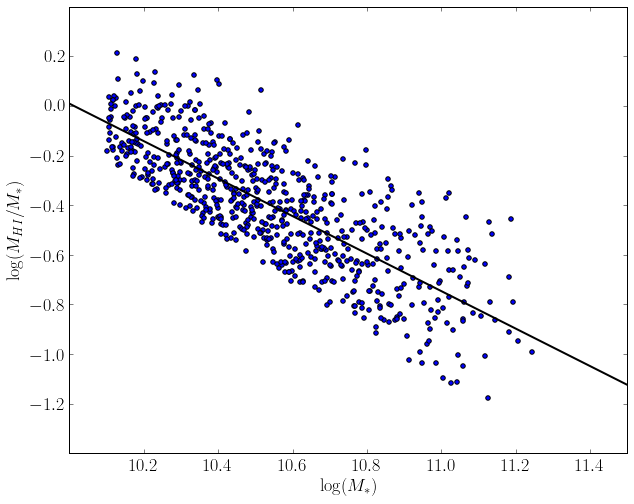

In [132]:
from scipy.optimize import curve_fit

mass = matched_galaxies['LOGMSTAR_BALDRY06']
log_fgas = (matched_a40['logMsun'] - matched_galaxies['LOGMSTAR_BALDRY06'])
#fgas = 10**log_fgas

def linear(x,m,c):
    return m*x + c

D = np.array([mass,log_fgas]).T
popt,pcov = curve_fit(linear,D[:,0],D[:,1])
_ = plt.scatter(mass,log_fgas)
x_guide = np.linspace(10,11.5,100)
plt.plot(x_guide,linear(x_guide,*popt),'k-',lw=2)
plt.xlabel('$\log(M_*)$')
plt.ylabel('$\log(M_{HI}/M_*)$')
plt.xlim(10,11.5)

log_fgas_expected = mass*popt[0] + popt[1]
gas_deficiency = log_fgas_expected - log_fgas

In [133]:
def cycle_3_parameters(a,b,c,a_label='a',b_label='b',c_label='c'):
    
    fig,axarr = plt.subplots(1,3,figsize=(20,6.7))
    plt.sca(axarr[0])
    xyz_contour(a,b,c,plot_bandwidth=None,
                xlabel=a_label,ylabel=b_label,zlabel=c_label)
    xy_contour(a,b,levels=[0.67,0.95])
    plt.sca(axarr[1])
    xyz_contour(b,c,a,plot_bandwidth=None,
                xlabel=b_label,ylabel=c_label,zlabel=a_label)
    xy_contour(b,c,levels=[0.67,0.95])
    plt.sca(axarr[2])
    xyz_contour(c,a,b,plot_bandwidth=None,
                xlabel=c_label,ylabel=a_label,zlabel=b_label)
    xy_contour(c,a,levels=[0.67,0.95])
    
    plt.tight_layout()
    
    return None

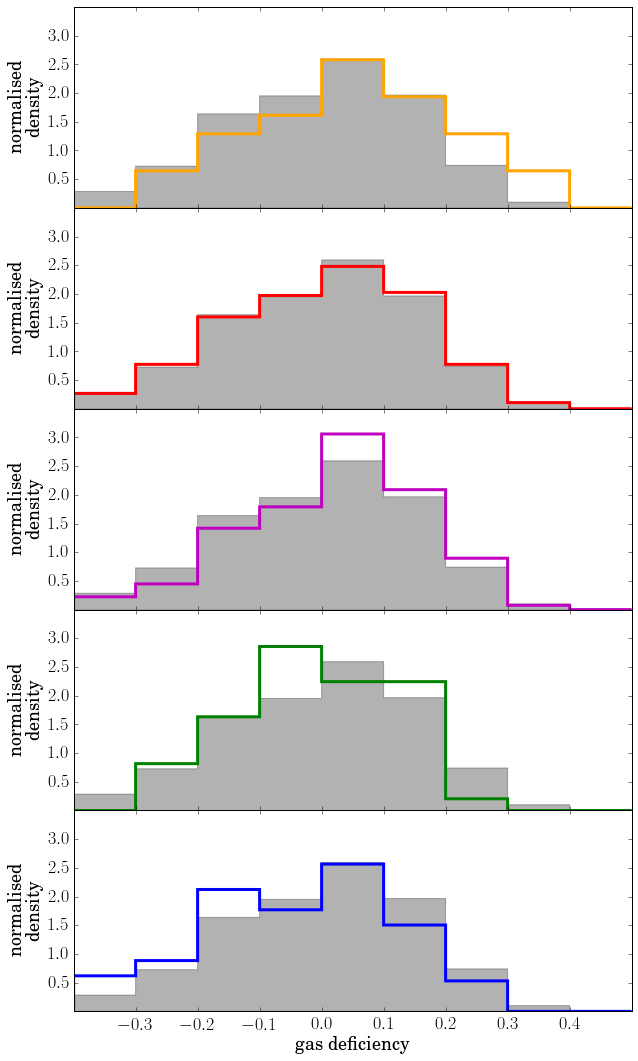

In [134]:
fig,axarr = plt.subplots(5,1,figsize=(10,18),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)

colors_long = ['orange','r','m','g','b','k']
bins = np.linspace(-0.4,0.5,10)
for m in range(5):
    
    col = gas_deficiency[matched_m == m]
    _ = axarr[m].hist(col,histtype='step',color=colors_long[m],lw=3,normed=True,zorder=1,bins=bins)
    _ = axarr[m].hist(gas_deficiency,histtype='stepfilled',color='k',alpha=0.3,zorder=0,normed=True,bins=bins)
    axarr[m].set_ylabel('normalised \n density')
axarr[-1].set_xlabel('gas deficiency')

In [135]:
from scipy.stats import binned_statistic

def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins


def get_xy_bins(x,y,bins):
    
    y_mean = []
    x_mean = []
    x_err = []
    y_err = []
    
    for b in np.unique(bins):
        x_bin = x[bins == b]
        y_bin = y[bins == b]
        x_mean.append(np.mean(x_bin))
        x_err.append(np.std(y_bin)/np.sqrt(len(x_bin)))
        y_mean.append(np.mean(y_bin))
        y_err.append(np.std(y_bin)/np.sqrt(len(y_bin)))
    
    out = Table(np.array([x_mean,y_mean,x_err,y_err]).T,names=('x','y','x_err','y_err'))
    return out
        
    
def xy_plot(x,y,nbins=10,plot_both=False,xlabel='x',ylabel='y',colors=['b','r']):
    
    _,bins = bin_by_column(x,nbins)
    xy = get_xy_bins(x,y,bins)
    plt.errorbar(xy['x'],xy['y'],xerr=xy['x_err'],yerr=xy['y_err'],fmt='o',lw=2,color=colors[0])
    if plot_both:
        _,bins = bin_by_column(y,nbins)
        xy = get_xy_bins(x,y,bins)
        plt.errorbar(xy['x'],xy['y'],xerr=xy['x_err'],yerr=xy['y_err'],fmt='o',lw=2,color=colors[1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return None

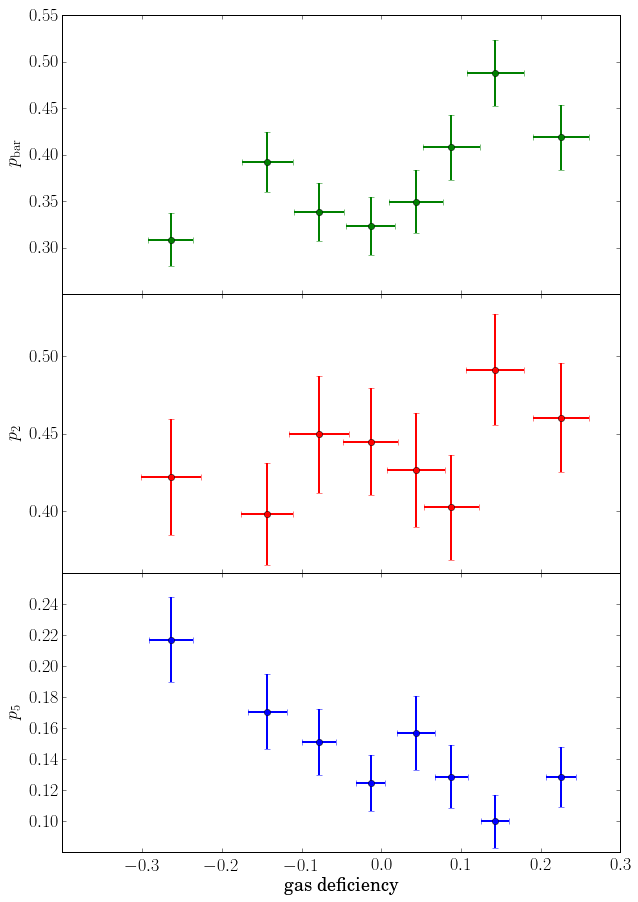

In [220]:
fig,axarr = plt.subplots(3,1,figsize=(10,15),sharex=True)
plt.subplots_adjust(hspace=0,wspace=0)

plt.sca(axarr[0])
xy_plot(gas_deficiency,p_bar,ylabel='$p_{\mathrm{bar}}$',xlabel='gas deficiency',nbins=8,colors=['g'])

plt.sca(axarr[1])
xy_plot(gas_deficiency,p_2,ylabel='$p_{\mathrm{2}}$',xlabel='gas deficiency',nbins=8,colors=['r'])

plt.sca(axarr[2])
xy_plot(gas_deficiency,p_5,ylabel='$p_{\mathrm{5}}$',xlabel='gas deficiency',nbins=8,colors=['b'])

best h found = 0.37
best h found = 0.24
best h found = 0.29
best h found = 0.32


[0, 1, -0.3, 0.3]

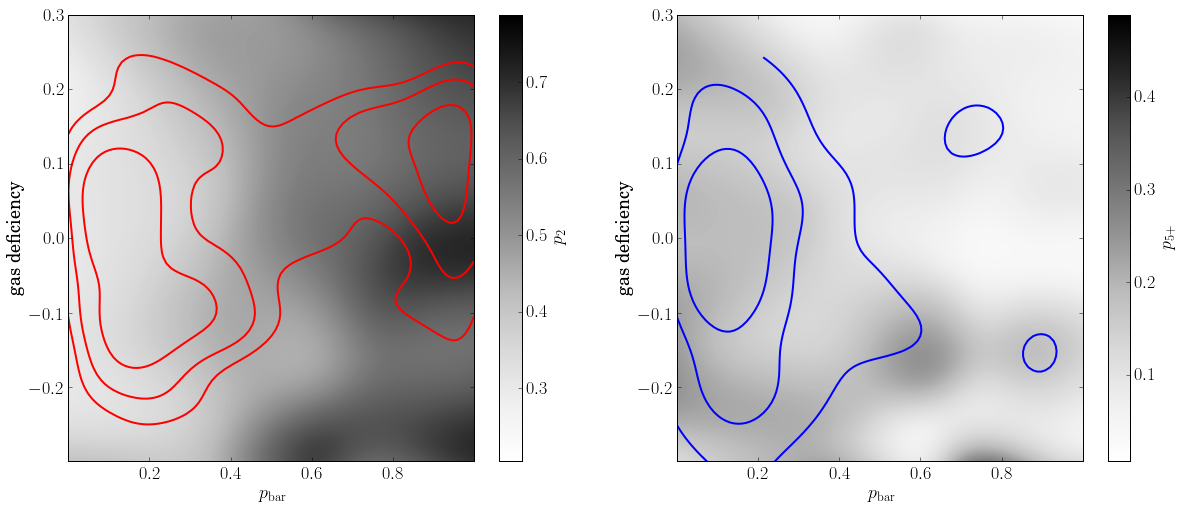

In [218]:
fig,axarr = plt.subplots(1,2,figsize=(20,8))

x,y = [p_bar,gas_deficiency]

x_,y_ = [p_bar[matched_m == 1],gas_deficiency[matched_m == 1]]

xlb = '$p_{\mathrm{bar}}$'
ylb = 'gas deficiency'

z = p_2
zlb = '$p_{\mathrm{2}}$'
plt.sca(axarr[0])
xyz_contour(x,y,z,xlabel=xlb,ylabel=ylb,zlabel=zlb)
xy_contour(x_,y_,levels=[0.75,0.5,0.25],color='r')
plt.axis([0,1,-0.3,0.3])

x_,y_ = [p_bar[(matched_m == 3) + (matched_m == 4)],
         gas_deficiency[(matched_m == 3) + (matched_m == 4)]]

z = p_5
zlb = '$p_{\mathrm{5+}}$'
plt.sca(axarr[1])
xyz_contour(x,y,z,xlabel=xlb,ylabel=ylb,zlabel=zlb)
xy_contour(x_,y_,levels=[0.75,0.5,0.25],color='b')
plt.axis([0,1,-0.3,0.3])

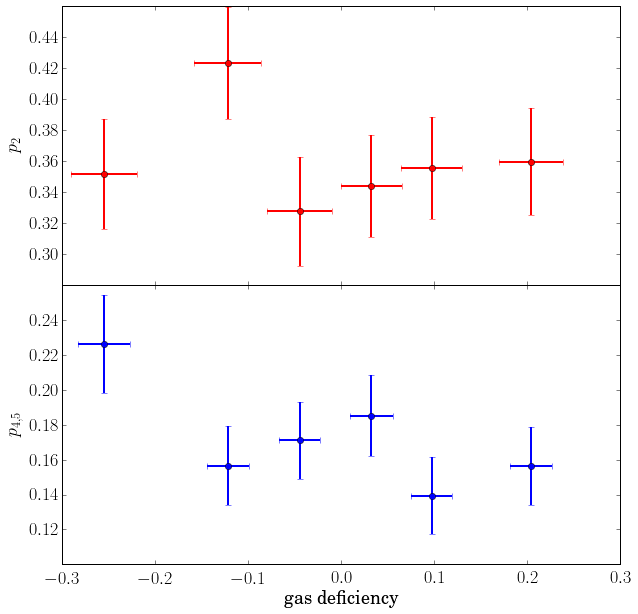

In [232]:
unbarred = matched_galaxies['t03_bar_a06_bar_debiased_rh'] < matched_galaxies['t03_bar_a07_no_bar_debiased_rh']

fig,axarr = plt.subplots(2,1,figsize=(10,10),sharex=True)
plt.subplots_adjust(hspace=0,wspace=0)

plt.sca(axarr[0])
xy_plot(gas_deficiency[unbarred],p_2[unbarred],ylabel='$p_{\mathrm{2}}$',xlabel='gas deficiency',nbins=6,colors=['r'])

plt.sca(axarr[1])
xy_plot(gas_deficiency[unbarred],p_5[unbarred],ylabel='$p_{\mathrm{4,5}}$',xlabel='gas deficiency',nbins=6,colors=['b'])